# How to wait for user input

!!! tip "Prerequisites"

    This guide assumes familiarity with the following concepts:

    * [Human-in-the-loop](/langgraphjs/concepts/human_in_the_loop)
    * [Breakpoints](/langgraphjs/concepts/breakpoints)
    * [LangGraph Glossary](/langgraphjs/concepts/low_level)

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). Waiting for human input is a common HIL interaction pattern, allowing the agent to ask the user clarifying questions and await input before proceeding. 

We can implement these in LangGraph using the [`interrupt()`](/langgraphjs/reference/functions/langgraph.interrupt-1.html) function. `interrupt` allows us to stop graph execution to collect input from a user and continue execution with collected input.

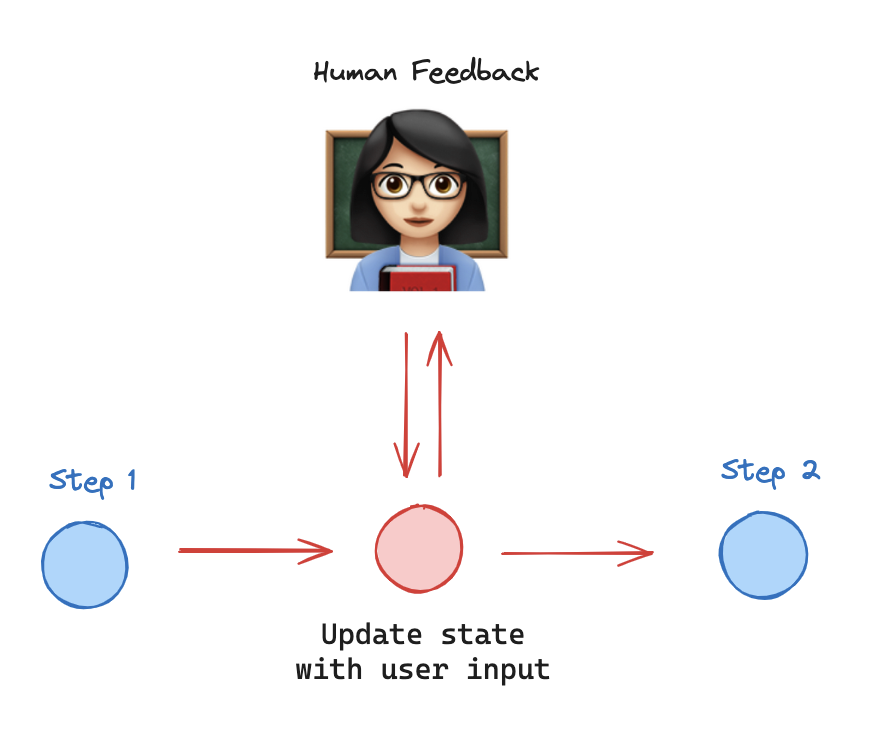

## Setup
First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core zod
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage

Let's explore a basic example of using human feedback. A straightforward approach is to create a node, **`human_feedback`**, designed specifically to collect user input. This allows us to gather feedback at a specific, chosen point in our graph.

Steps:

1. **Call `interrupt()`** inside the **`human_feedback`** node.  
2. We set up a [checkpointer](/langgraphjs/concepts/low_level/#persistence) to save the state of the graph up until this node.
3. **Use `new Command({ resume: ... })`** to provide the requested value to the **`human_feedback`** node and resume execution.

In [1]:
import { StateGraph, Annotation, START, END, interrupt, MemorySaver } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  input: Annotation<string>,
  userFeedback: Annotation<string>
});

const step1 = (_state: typeof StateAnnotation.State) => {
  console.log("---Step 1---");
  return {};
}

const humanFeedback = (_state: typeof StateAnnotation.State) => {
  console.log("--- humanFeedback ---");
  const feedback: string = interrupt("Please provide feedback");
  return {
    userFeedback: feedback
  };
}

const step3 = (_state: typeof StateAnnotation.State) => {
  console.log("---Step 3---");
  return {};
}

const builder = new StateGraph(StateAnnotation)
    .addNode("step1", step1)
    .addNode("humanFeedback", humanFeedback)
    .addNode("step3", step3)
    .addEdge(START, "step1")
    .addEdge("step1", "humanFeedback")
    .addEdge("humanFeedback", "step3")
    .addEdge("step3", END);


// Set up memory
const memory = new MemorySaver()

// Add 
const graph = builder.compile({
  checkpointer: memory,
});

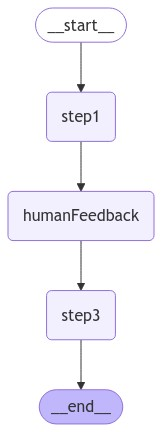

In [2]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

Run until our breakpoint in the `humanFeedback` node:

In [3]:
// Input
const initialInput = { input: "hello world" };

// Thread
const config = { configurable: { thread_id: "1" } };

// Run the graph until the first interruption
for await (const event of await graph.stream(initialInput, config)) {
  console.log(event);
}

// Will log when the graph is interrupted, after step 2.
console.log("--- GRAPH INTERRUPTED ---");

---Step 1---
{}
--- humanFeedback ---
{
  __interrupt__: [
    {
      value: 'Please provide feedback',
      when: 'during',
      resumable: true,
      ns: [Array]
    }
  ]
}
--- GRAPH INTERRUPTED ---


Now, we can just manually update our graph state with with the user input - 

In [4]:
import { Command } from "@langchain/langgraph";

// Continue the graph execution
for await (const event of await graph.stream(
  new Command({ resume: "go to step 3! "}),
  config,
)) {
  console.log(event);
  console.log("\n====\n");
}

--- humanFeedback ---
{ humanFeedback: { userFeedback: 'go to step 3! ' } }

====

---Step 3---
{}

====



We can see our feedback was added to state - 

In [5]:
(await graph.getState(config)).values

{ input: 'hello world', userFeedback: 'go to step 3! ' }


## Agent

In the context of agents, waiting for user feedback is useful to ask clarifying questions.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use Anthropic's models and a mock tool (purely for demonstration purposes).

In [7]:
// Set up the tool
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from "@langchain/core/tools";
import { StateGraph, MessagesAnnotation, START, END, MemorySaver } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { AIMessage, ToolMessage } from "@langchain/core/messages";
import { z } from "zod";

const search = tool((_) => {
  return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈.";
}, {
  name: "search",
  description: "Call to surf the web.",
  schema: z.string(),
})

const tools = [search]
const toolNode = new ToolNode<typeof MessagesAnnotation.State>(tools)

// Set up the model
const model = new ChatAnthropic({ model: "claude-3-5-sonnet-20240620" })

const askHumanTool = tool((_) => {
  return "The human said XYZ";
}, {
  name: "askHuman",
  description: "Ask the human for input.",
  schema: z.string(),
});


const modelWithTools = model.bindTools([...tools, askHumanTool])

// Define nodes and conditional edges

// Define the function that determines whether to continue or not
function shouldContinue(state: typeof MessagesAnnotation.State): "action" | "askHuman" | typeof END {
  const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
  // If there is no function call, then we finish
  if (lastMessage && !lastMessage.tool_calls?.length) {
    return END;
  }
  // If tool call is askHuman, we return that node
  // You could also add logic here to let some system know that there's something that requires Human input
  // For example, send a slack message, etc
  if (lastMessage.tool_calls?.[0]?.name === "askHuman") {
    console.log("--- ASKING HUMAN ---")
    return "askHuman";
  }
  // Otherwise if it isn't, we continue with the action node
  return "action";
}


// Define the function that calls the model
async function callModel(state: typeof MessagesAnnotation.State): Promise<Partial<typeof MessagesAnnotation.State>> {
  const messages = state.messages;
  const response = await modelWithTools.invoke(messages);
  // We return an object with a messages property, because this will get added to the existing list
  return { messages: [response] };
}


// We define a fake node to ask the human
function askHuman(state: typeof MessagesAnnotation.State): Partial<typeof MessagesAnnotation.State> {
  const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
  const toolCallId = lastMessage.tool_calls?.[0].id;
  const location: string = interrupt("Please provide your location:");
  const newToolMessage = new ToolMessage({
    tool_call_id: toolCallId!,
    content: location,
  })
  return { messages: [newToolMessage] };
}

// Define a new graph
const messagesWorkflow = new StateGraph(MessagesAnnotation)
  // Define the two nodes we will cycle between
  .addNode("agent", callModel)
  .addNode("action", toolNode)
  .addNode("askHuman", askHuman)
  // We now add a conditional edge
  .addConditionalEdges(
    // First, we define the start node. We use `agent`.
    // This means these are the edges taken after the `agent` node is called.
    "agent",
    // Next, we pass in the function that will determine which node is called next.
    shouldContinue
  )
  // We now add a normal edge from `action` to `agent`.
  // This means that after `action` is called, `agent` node is called next.
  .addEdge("action", "agent")
  // After we get back the human response, we go back to the agent
  .addEdge("askHuman", "agent")
  // Set the entrypoint as `agent`
  // This means that this node is the first one called
  .addEdge(START, "agent");


// Setup memory
const messagesMemory = new MemorySaver();

// Finally, we compile it!
// This compiles it into a LangChain Runnable,
// meaning you can use it as you would any other runnable
const messagesApp = messagesWorkflow.compile({
    checkpointer: messagesMemory,
});

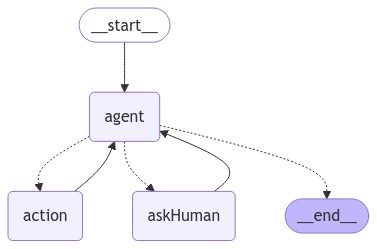

In [8]:
import * as tslab from "tslab";

const drawableGraph2 = messagesApp.getGraph();
const image2 = await drawableGraph2.drawMermaidPng();
const arrayBuffer2 = await image2.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer2));

## Interacting with the Agent

We can now interact with the agent. Let's ask it to ask the user where they are, then tell them the weather. 

This should make it use the `askHuman` tool first, then use the normal tool. Note that we switch to use `streamMode: "values"` to just return the update messages at each point:

In [9]:
// Input
const input = {
  role: "user",
  content: "Use the search tool to ask the user where they are, then look up the weather there",
}

// Thread
const config2 = { configurable: { thread_id: "3" }, streamMode: "values" as const };

for await (const event of await messagesApp.stream({
  messages: [input]
}, config2)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg.getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}

================================ human Message (1) =================================
Use the search tool to ask the user where they are, then look up the weather there
--- ASKING HUMAN ---
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I'll use the askHuman tool to ask the user about their location, and then use the search tool to look up the weather for that location. Let's start by asking the user where they are."
  },
  {
    type: 'tool_use',
    id: 'toolu_015UDVFoXcMV7KjRqPY78Umk',
    name: 'askHuman',
    input: {
      input: 'Where are you currently located? Please provide a city and country or region.'
    }
  }
]


In [10]:
console.log("next: ", (await messagesApp.getState(config2)).next)

next:  [ 'askHuman' ]


You can see that our graph got interrupted inside the `askHuman` node, which is now waiting for a `location` to be provided. We can provide this value by invoking the graph with a `new Command({ resume: "<location>" })` input:

In [11]:
import { Command } from "@langchain/langgraph";

// Continue the graph execution
for await (const event of await messagesApp.stream(
  new Command({ resume: "San Francisco" }),
  config2,
)) {
  console.log(event);
  console.log("\n====\n");
}

{
  messages: [
    HumanMessage {
      "id": "cfb461cb-0da1-48b4-acef-e3bf0d3a4e6c",
      "content": "Use the search tool to ask the user where they are, then look up the weather there",
      "additional_kwargs": {},
      "response_metadata": {}
    },
    AIMessage {
      "id": "msg_01TA2zHbbrenm7KXSUdcFdXD",
      "content": [
        {
          "type": "text",
          "text": "Certainly! I'll use the askHuman tool to ask the user about their location, and then use the search tool to look up the weather for that location. Let's start by asking the user where they are."
        },
        {
          "type": "tool_use",
          "id": "toolu_015UDVFoXcMV7KjRqPY78Umk",
          "name": "askHuman",
          "input": {
            "input": "Where are you currently located? Please provide a city and country or region."
          }
        }
      ],
      "additional_kwargs": {
        "id": "msg_01TA2zHbbrenm7KXSUdcFdXD",
        "type": "message",
        "role": "assistant"

**Note:** The `interrupt` function propagates by throwing a special `GraphInterrupt` error. Therefore, you should avoid using `try/catch` blocks around the `interrupt` function - or if you do, ensure that the `GraphInterrupt` error is thrown again within your `catch` block.